In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pip install -U xgboost

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import time
import datetime
import statistics
import xgboost as xgb
import pickle
#Scikit-learn modules
from sklearn.tree  import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

%cd /content/drive/MyDrive/Colab\ Notebooks/CarPricePrediction
seed = 42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/Colab Notebooks/CarPricePrediction


# Autos Data Preprocess

In [5]:
def preprocess_autos(freq_encoding=True, categorical=False):
    if freq_encoding and categorical:
        assert 'Do not make them both True!'

    df = pd.read_csv('Data/autos.csv', index_col='index')
    df = df.loc[(df['price'] > 0) & (df['price'] < 35000)]
    df.rename(columns={'price': 'Price'}, inplace=True)

    # datetime to timestamp
    df['createdTimestamp'] = df['dateCreated'].apply(lambda t: time.mktime(datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S").timetuple())).astype(int)
    df['createdTimestamp'] = df['createdTimestamp'] - df['createdTimestamp'].min()
    
    # age
    df['age'] = 2016 - df['yearOfRegistration']
    df['age'] = df['age'].apply(lambda age: np.nan if age < 0 or age > 80 else age)
    
    # model
    df['model'] = df['model'].apply(lambda x: str(x).lower() if not x is np.nan else np.nan)
    
    # power
    df['powerPS'] = df['powerPS'].apply(lambda p: p if p > 70 and p < 400 else np.nan)
    
    # gearbox
    df['gearbox'] = (df['gearbox'] == 'automatik').astype(int)

    # damage
    df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda x: int(x == 'nein') if not x is np.nan else np.nan)
    
    # seller
    df['seller'] = (df['seller'] == 'privat').astype(int)
    
    # offer type
    df['offerType'] = (df['offerType'] == 'Angebot').astype(int)
    
    df.drop(columns=['dateCrawled', 'yearOfRegistration', 'monthOfRegistration', 'abtest', 'nrOfPictures', 'name', 'lastSeen', 'dateCreated', 'postalCode'], inplace=True)

    le_v = LabelEncoder()
    le_m = LabelEncoder()
    le_b = LabelEncoder()
    le_f = LabelEncoder()
    df['vehicleType'] = le_v.fit_transform(df['vehicleType'])
    df['model'] = le_m.fit_transform(df['model'])
    df['brand'] = le_b.fit_transform(df['brand'])
    df['fuelType'] = le_f.fit_transform(df['fuelType'])

    imp = IterativeImputer(max_iter=10, random_state=seed)
    df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

    if freq_encoding:
        enc = (df.groupby('vehicleType').size()) / len(df)
        df['vehicleType'] = df['vehicleType'].apply(lambda x: enc[x])
        
        enc = (df.groupby('model').size()) / len(df)
        df['model'] = df['model'].apply(lambda x: enc[x])
        
        enc = (df.groupby('fuelType').size()) / len(df)
        df['fuelType'] = df['fuelType'].apply(lambda x: enc[x])
        
        enc = (df.groupby('brand').size()) / len(df)
        df['brand'] = df['brand'].apply(lambda x: enc[x])

    if categorical:
        df['vehicleType'] = le_v.inverse_transform(df['vehicleType'].astype(int))
        df['model'] = le_m.inverse_transform(df['model'].astype(int))
        df['brand'] = le_b.inverse_transform(df['brand'].astype(int))
        df['fuelType'] = le_f.inverse_transform(df['fuelType'].astype(int))


        df['vehicleType'] = df['vehicleType'].astype('category')
        df['model'] = df['model'].astype('category')
        df['fuelType'] = df['fuelType'].astype('category')
        df['brand'] = df['brand'].astype('category')

        
    return df

In [8]:
data = preprocess_autos()

In [ ]:
X, y = data.drop(columns=['Price']), data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

In [ ]:
# Hypothesis: Important model features are represented in the Name column and if they are similar they can be in the same category.
def editDistance(str1, str2, m, n):
    if m == 0:
        return n
    if n == 0:
        return m
    if str1[m-1] == str2[n-1]:
        return editDistance(str1, str2, m-1, n-1)
    return 1 + min(
            editDistance(str1, str2, m, n-1),
            editDistance(str1, str2, m-1, n),
            editDistance(str1, str2, m-1, n-1)
            )

In [ ]:
for col in data.columns:
    print(col, data[col].unique())

seller ['privat' 'gewerblich']
offerType ['Angebot' 'Gesuch']
price [  480 18300  9800 ... 18429 24895 10985]
vehicleType [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi'
 'andere']
gearbox ['manuell' 'automatik' nan]
powerPS [ nan 190. 163.  75. 102. 109. 125. 101. 105. 140. 115. 131. 136. 160.
 231.  90. 118. 193.  99. 113. 218. 122. 129. 306.  95. 177.  80. 170.
 143. 286. 232. 150. 156.  82. 204. 155. 185.  87. 180.  86.  84. 303.
 224. 235. 200. 178. 265.  77. 110. 144. 120. 116. 184. 126.  88. 194.
 305. 197. 179. 250. 313. 165.  98. 130. 114. 211. 326. 201. 213. 107.
  83. 174. 100. 220.  85.  73. 192. 299.  74. 147. 310.  71.  97. 239.
 295. 203. 300. 103. 245. 258. 292. 320.  81. 148. 354. 145. 280. 260.
 104. 188. 333. 186. 117. 141. 132. 234. 158. 272.  92. 135. 230. 209.
 146. 106. 166. 276. 344. 349.  72. 249. 237. 111. 279. 138. 256. 175.
  96. 226. 301. 334. 128. 133. 124. 219. 241. 167.  94. 182. 196. 238.
 277. 228. 112. 139.  79. 360. 243. 252. 396. 

In [ ]:
def name2features(row):
    #print(row)
    name = str(row['name']).lower().split('_')
    #print(name)
    if str(row['brand']).lower() in name:
        name.remove(row['brand'].lower())
    if str(row['model']).lower() in name:
        name.remove(row['model'].lower())
    return name
        
# data.apply(name2features, axis=1)
# Did not use it but it could be used

In [ ]:
imp = SimpleImputer(strategy="most_frequent")
imp.fit_transform(data)

array([[1.00000e+00, 1.00000e+00, 4.80000e+02, ..., 1.00000e+00,
        6.43680e+07, 2.30000e+01],
       [1.00000e+00, 1.00000e+00, 1.83000e+04, ..., 0.00000e+00,
        6.43680e+07, 5.00000e+00],
       [1.00000e+00, 1.00000e+00, 9.80000e+03, ..., 1.00000e+00,
        6.35040e+07, 1.20000e+01],
       ...,
       [1.00000e+00, 1.00000e+00, 9.20000e+03, ..., 1.00000e+00,
        6.39360e+07, 2.00000e+01],
       [1.00000e+00, 1.00000e+00, 3.40000e+03, ..., 1.00000e+00,
        6.40224e+07, 1.40000e+01],
       [1.00000e+00, 1.00000e+00, 2.89900e+04, ..., 1.00000e+00,
        6.28992e+07, 3.00000e+00]])

Text(0, 0.5, 'Number of Cars')

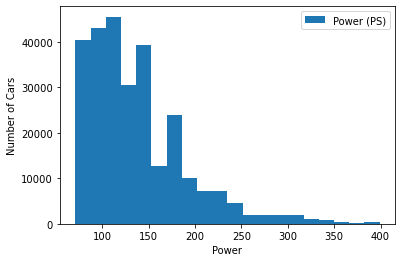

In [ ]:
plt.hist(data['powerPS'], bins=20, label='Power (PS)')
plt.legend()
plt.xlabel('Power')
plt.ylabel('Number of Cars')
# plt.savefig('Power.png')

# Preprocessing for Other Dataset

In [ ]:
train = pd.read_csv("Data/train-data.csv")
test = pd.read_csv("Data/train-data.csv")

In [ ]:
df = pd.concat([train, test], ignore_index=True)

In [ ]:
df.isna().sum()

Unnamed: 0               0
Name                     0
Location                 0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Mileage                  4
Engine                  72
Power                   72
Seats                   84
New_Price            10390
Price                    0
dtype: int64

In [ ]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [ ]:
location_dict = {
        'Mumbai':(19.07, 72.87),
        'Pune':(18.52, 73.85),
        'Chennai':(13.08, 80.27),
        'Coimbatore':(11.01, 76.95),
        'Hyderabad': (17.38, 78.48),
        'Jaipur':(26.91, 75.78),
        'Kochi':(9.93, 76.26),
        'Kolkata':(22.57, 88.36),
        'Delhi':(28.70, 77.10),
        'Bangalore':(12.97, 77.59),
        'Ahmedabad':(23.02, 72.57)
        }

def preprocess(x):
    cc_str = str(x["Engine"])[:-3]
    if cc_str != "":
        x["Engine"] = int(cc_str)
    # 0 is out of domain
    # 0 will change with median
    
    tmp = x["Name"].split()
    x["Brand"] = tmp[0]
    x["Model"] = tmp[1]
    
    tmp = location_dict[x["Location"]]
    x["Longitude"] = tmp[0]
    x["Latitude"] = tmp[1]
    
    if x["Power"] != "" and x["Power"] != "null bhp":
        power_str = str(x["Power"]).split()[0]
        x["Power"] = float(power_str)
    else: x["Power"] = 0
    
    if x["Mileage"] != "":
        power_str = str(x["Mileage"]).split()[0]
        x["Mileage"] = float(power_str)
    else: x["Mileage"] = 0
    
    x["Age"] = 2019 - x["Year"]
    
    if x["Owner_Type"] == "First":
        x["Owner_Type"] = 1
    elif x["Owner_Type"] == "Second":
        x["Owner_Type"] = 2
    elif x["Owner_Type"] == "Third":
        x["Owner_Type"] = 3
    elif x["Owner_Type"] == "Fourth & Above":
        x["Owner_Type"] = 4
        
    if x["Fuel_Type"] == "CNG" or x["Fuel_Type"] == "LPG":
        x["Fuel_Type"] = "Gas"
    return x

In [ ]:
df = df.apply(preprocess, axis=1)
df.drop(columns=["Name", "Location", "Unnamed: 0", "Year", "New_Price"], inplace=True)

In [ ]:
df

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,72000,Gas,Manual,1,26.60,998.0,58.16,5.0,1.75,Maruti,Wagon,19.07,72.87,9
1,41000,Diesel,Manual,1,19.67,1582.0,126.20,5.0,12.50,Hyundai,Creta,18.52,73.85,4
2,46000,Petrol,Manual,1,18.20,1199.0,88.70,5.0,4.50,Honda,Jazz,13.08,80.27,8
3,87000,Diesel,Manual,1,20.77,1248.0,88.76,7.0,6.00,Maruti,Ertiga,13.08,80.27,7
4,40670,Diesel,Automatic,2,15.20,1968.0,140.80,5.0,17.74,Audi,A4,11.01,76.95,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12033,27365,Diesel,Manual,1,28.40,1248.0,74.00,5.0,4.75,Maruti,Swift,28.70,77.10,5
12034,100000,Diesel,Manual,1,24.40,1120.0,71.00,5.0,4.00,Hyundai,Xcent,26.91,75.78,4
12035,55000,Diesel,Manual,2,14.00,2498.0,112.00,8.0,2.90,Mahindra,Xylo,26.91,75.78,7
12036,46000,Petrol,Manual,1,18.90,998.0,67.10,5.0,2.65,Maruti,Wagon,22.57,88.36,6


In [ ]:
df.drop(df[df["Kilometers_Driven"] == df["Kilometers_Driven"].max()].index, inplace=True)
df.drop(df[df["Fuel_Type"] == "Electric"].index, inplace=True)

In [ ]:
return
def fill_median(x):
    # na is replaced with 0 previously
    if x["Power"] == 0:
        x["Power"] = train["Power"].median()

    if x["Mileage"] == 0:
        x["Mileage"] = train["Mileage"].median()
    
    return x
train = train.apply(fill_median, axis=1)

NameError: ignored

In [ ]:
df["Brand"] = df["Brand"].astype("category")
df["Model"] = df["Model"].astype("category")
df["Fuel_Type"] = df["Fuel_Type"].astype("category")
df["Transmission"] = df["Transmission"].astype("category")

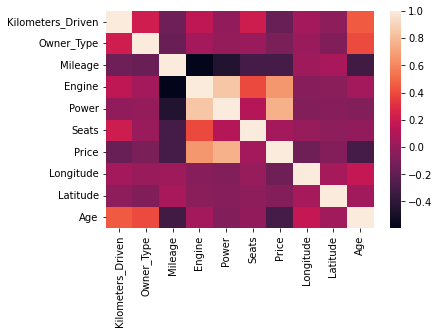

In [ ]:
figure = sns.heatmap(df.corr())
# Power and engine has a great correlation can be used together
# Curse of dimensionality can be avoided

In [ ]:
df.to_pickle("Data/preprocessed_dataframe.pkl")

# Save

In [ ]:
df = pd.read_pickle("Data/preprocessed_dataframe.pkl")

In [ ]:
scaler = StandardScaler()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns
numeric_columns = np.delete(numeric_columns, np.argwhere(numeric_columns == "Price"))
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [ ]:
df.head()

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,0.378244,Gas,Manual,-0.444686,1.847294,-1.037315,-0.957299,-0.344737,1.75,Maruti,Wagon,0.182624,-1.084610,1.026889
1,-0.440100,Diesel,Manual,-0.444686,0.334922,-0.065368,0.270238,-0.344737,12.50,Hyundai,Creta,0.089273,-0.844843,-0.502336
2,-0.308109,Petrol,Manual,-0.444686,0.014115,-0.702792,-0.406314,-0.344737,4.50,Honda,Jazz,-0.834060,0.725875,0.721044
3,0.774217,Diesel,Manual,-0.444686,0.574981,-0.621241,-0.405232,2.127601,6.00,Maruti,Ertiga,-0.834060,0.725875,0.415199
4,-0.448811,Diesel,Automatic,1.746332,-0.640591,0.577049,0.533643,-0.344737,17.74,Audi,A4,-1.185402,-0.086397,0.109354


In [ ]:
df = df[df['Price'] < 65]

In [ ]:
# df["Mileage"] = df["Mileage"].fillna(df["Mileage"].median())

In [ ]:
df.isna().sum()

Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               72
Power                72
Seats                84
Price                 0
Brand                 0
Model                 0
Longitude             0
Latitude              0
Age                   0
dtype: int64

In [ ]:
imputer = KNNImputer(n_neighbors=10)
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
df.isna().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
Model                0
Longitude            0
Latitude             0
Age                  0
dtype: int64

# Decision Tree & Random Forest

In [ ]:
df_encoded = df.copy()

trans_le = LabelEncoder()
df_encoded["Transmission"] = trans_le.fit_transform(df["Transmission"]).astype(int)

ft_le = LabelEncoder()
df_encoded["Fuel_Type"] = ft_le.fit_transform(df["Fuel_Type"]).astype(int)

brand_le = LabelEncoder()
df_encoded["Brand"] = brand_le.fit_transform(df["Brand"]).astype(int)

model_le = LabelEncoder()
df_encoded["Model"] = model_le.fit_transform(df["Model"]).astype(int)

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit_transform(df["Transmission"])

ValueError: Expected 2D array, got 1D array instead:
array=['Manual' 'Manual' 'Manual' ... 'Manual' 'Manual' 'Manual'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Decision Tree

In [ ]:
def decision_tree(df):
    X, y = df.drop(columns="Price"), df["Price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

    dt = DecisionTreeRegressor(min_samples_leaf=50, random_state=seed)
    dt.fit(X_train, y_train)
    
    # test
    score = dt.score(X_test, y_test)
    print(score)
    y_pred = dt.predict(X_test)
    mse = mean_squared_error(y_test/y_test, y_pred/y_test)
    print(mse)
    percentage_error = sum(abs(y_test/y_test - y_pred/y_test)) / len(y_test)
    print(f'%Error: {percentage_error}')

    return dt

In [ ]:
data = preprocess_autos()

In [ ]:
dt = decision_tree(data)

0.8585930886442061
30665.1628526815
%Error: 6.994674909048534


## Random Forest

In [ ]:
def random_forest(df, max_depth=25):
    X, y = df.drop(columns="Price"), df["Price"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

    reg = RandomForestRegressor(max_depth=max_depth, random_state=seed)
    reg.fit(X_train, y_train)

    # test
    score = reg.score(X_val, y_val)
    print(score)
    y_pred = reg.predict(X_val)
    mse = mean_squared_error(y_val/y_val, y_pred/y_val)
    print(mse)
    percentage_error = sum(abs(y_test/y_val - y_pred/y_val)) / len(y_val)
    print(f'%Error: {percentage_error}')
    
    return reg

In [ ]:
reg = random_forest(data)

0.9063107295371774
24915.487098705216
%Error: 5.95745478789801


In [ ]:
random_forest_30 = random_forest(data, max_depth=30)

0.9057906344015276
24919.205506909755
%Error: 5.927423852383694


In [ ]:
random_forest_20 = random_forest(data, max_depth=20)

0.9071363774826621
25171.617250164683
%Error: 6.110510824132385


In [ ]:
random_forest_23 = random_forest(data, max_depth=23)

0.9067122366587266
25098.468017613763
%Error: 5.999359913629136


In [ ]:
random_forest_26 = random_forest(data, max_depth=26)

0.9061939324641585
25067.89243435537
%Error: 5.959083029751111


In [ ]:
random_forest_24 = random_forest(data, max_depth=24)

0.906604034758764
25139.012962719567
%Error: 5.974085320139734


# XGBOOST

In [24]:
def xgboost_categorical(df):
    X, y = df.drop(columns=['Price']), df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)
    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    xgbr = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True, verbosity=0, random_state=seed)
    xgbr.fit(X_train, y_train)
    
    # test
    score = xgbr.score(X_train, y_train)
    # print(score)
    y_pred = xgbr.predict(X_test)
    mse = mean_squared_error(y_test/y_test, y_pred/y_test)
    # print(mse)
    percentage_error = sum(abs(y_test/y_test - y_pred/y_test)) / len(y_test)
    # print(f'%Error: {percentage_error}')
    return xgbr

In [ ]:
def xgboost(df):
    X, y = df.drop(columns=['Price']), df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]

    kfold = KFold(n_splits=10, shuffle=True)

    xgbr = xgb.XGBRegressor(base_score=300, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.6, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
    xgbr.fit(X_train, y_train)
    
    # test
    score = xgbr.score(X_train, y_train)
    print(score)
    y_pred = xgbr.predict(X_test)
    mse = mean_squared_error(y_test/y_test, y_pred/y_test)
    print(mse)
    percentage_error = sum(abs(y_test/y_test - y_pred/y_test)) / len(y_test)
    print(f'%Error: {percentage_error}')
    return xgbr

In [ ]:
# freq encoding
autos_xgb = xgboost(imp_data)

0.8843634050003426
27677.58387524668
%Error: 6.6362039450503305


In [ ]:
data2 = preprocess_autos(freq_encoding=False)

In [ ]:
le = LabelEncoder()
data2['vehicleType'] = le.fit_transform(data2['vehicleType'])
data2['model'] = le.fit_transform(data2['model'])
data2['brand'] = le.fit_transform(data2['brand'])
data2['fuelType'] = le.fit_transform(data2['fuelType'])

In [ ]:
# without freq encoding
autos_xgb2 = xgboost(data2)

0.8506236550481429
48005.56184102757
%Error: 9.725330802800057


In [ ]:
data3 = preprocess_autos(freq_encoding=False, categorical=True)

In [ ]:
# xgb categorical
xgbr3 = xgboost_categorical(data3)

0.9270441029355446
27237.837612864103
%Error: 6.320427451706816


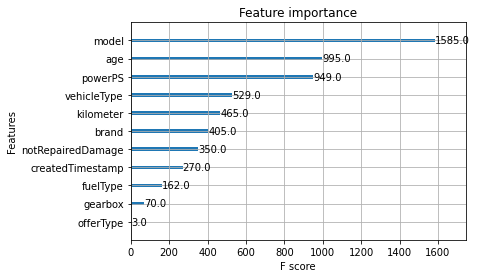

In [ ]:
xgb.plot_importance(xgbr3)

In [ ]:
data4 = data.drop(columns=['age'])
data5 = data.drop(columns=['offerType'])

In [ ]:
print('Without age column')
xgbr4 = xgboost_categorical(data4)
print('Without offer type column')
xgbr5 = xgboost_categorical(data4)

Without age column
0.834120145147523
39699.22362275055
%Error: 7.60129831266251
Without offer type column
0.834120145147523
39699.22362275055
%Error: 7.60129831266251


# Ensemble

In [ ]:
with open('random_forest.pkl', 'wb') as file:
    pickle.dump(reg, file)

In [6]:
with open("random_forest.pkl", 'rb') as file:
    reg = pickle.load(file)

In [ ]:
with open('xgb.pkl', 'wb') as file:
    pickle.dump(xgbr3, file)

In [7]:
with open("xgb.pkl", 'rb') as file:
    xgbr = pickle.load(file)

In [10]:
def ensemble(xgbr, reg, df, df2):
    X, y = df.drop(columns=['Price']), df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)
    
    X2, y2 = df2.drop(columns=['Price']), df['Price']
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=seed, shuffle=True)
    
    p = 0.4

    # test
    y_pred = p * xgbr.predict(X_test2) + (1-p) * reg.predict(X_test)
    mse = mean_squared_error(y_test/y_test, y_pred/y_test)
    print(mse)
    percentage_error = sum(abs(y_test/y_test - y_pred/y_test)) / len(y_test)
    print(f'%Error: {percentage_error}')

In [27]:
data = preprocess_autos()
data2 = preprocess_autos(freq_encoding=False, categorical=True)
ensemble(xgbr, reg, data, data2)

24351.57946119286
%Error: 6.045714125153302


In [28]:
def concat_ensemble(reg, df, df2):
    X, y = df.drop(columns=['Price']), df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

    X2, y2 = df2.drop(columns=['Price']), df2['Price']
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=seed, shuffle=True)
    X_train2['pred'] = reg.predict(X_train)
    X_train2['Price'] = y2
    train2 = X_train2
    xgbr = xgboost_categorical(train2)

    # test
    X_test2['pred'] = reg.predict(X_test)
    y_pred = xgbr.predict(X_test2)
    mse = mean_squared_error(y_test/y_test, y_pred/y_test)
    print(mse)
    percentage_error = sum(abs(y_test/y_test - y_pred/y_test)) / len(y_test)
    print(f'%Error: {percentage_error}')

In [29]:
concat_ensemble(reg, data, data2)

23803.28841949335
%Error: 5.60536744247092


In [ ]:
ensemble(xgbr3, reg, data, data3)

24351.57946119286
%Error: 6.045714125153302


# XGBOOST with PCA

In [ ]:
data = preprocess_autos()

In [ ]:
mse = dict()
score = dict()
X, y = data.drop(columns=['Price']), data['Price']
for n in range(1, 13):
    pca = PCA(n_components = n)
    X_pca = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 42, shuffle = True)

    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    
    xgbr = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True, verbosity=0, random_state=seed)
    xgbr.fit(X_train, y_train)
    
    score[n] = xgbr.score(X_test, y_test)
    y_pred = xgbr.predict(X_test)
    mse[n] = mean_squared_error(y_test, y_pred)
    

Text(0.5, 1.0, 'PCA')

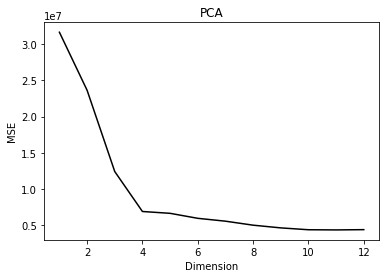

In [ ]:
# Has 13 dimension originally
plt.plot(list(mse.keys()), list(mse.values()), color="black")
plt.xlabel("Dimension")
plt.ylabel("MSE")
plt.title("PCA")

# Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

data = preprocess_autos()
X, y = data.drop(columns=['Price']), data['Price']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = seed)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)


train = torch.utils.data.TensorDataset(X_train,y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 16, shuffle = True)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(12, 30)
        self.fc2 = nn.Linear(30, 14)
        self.fc3 = nn.Linear(14, 5)
        self.fc4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = Net()
print(model)

Net(
  (fc1): Linear(in_features=12, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=14, bias=True)
  (fc3): Linear(in_features=14, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)


In [ ]:
data.isnull().sum()

seller               0
offerType            0
Price                0
vehicleType          0
gearbox              0
powerPS              0
model                0
kilometer            0
fuelType             0
brand                0
notRepairedDamage    0
createdTimestamp     0
age                  0
dtype: int64

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True)
device = 'cuda:0'

In [ ]:
model.to(device)

Net(
  (fc1): Linear(in_features=12, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=14, bias=True)
  (fc3): Linear(in_features=14, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
for X, y in train_loader:
    X

In [ ]:
model.train()
epochs = 1
loss = 0.
for epoch in range(epochs):
    epoch_loss = 0.
    for X, y in train_loader:
        X, y = X.to(torch.float32), y.to(torch.float32)
        optimizer.zero_grad()
        output = model(X.to(device))
        loss = loss_fn(output.to(device), y.to(device))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss += epoch_loss

In [ ]:
# test
with torch.no_grad():
    predicted = []
    test_labels = []
    for X, y in test_loader:
        X, y = X.to(torch.float32), y.to(torch.float32)
        y_hat = model(X.to(device)).to(device)
        print(y_hat)
        # test_labels.append(y)
        # predicted.append(y_hat)

In [ ]:
mse = mean_squared_error(test_labels/test_labels, y_pred/test_labels)
print(mse)
percentage_error = sum(abs(test_labels/test_labels - y_pred/test_labels)) / len(test_labels)
print(f'%Error: {percentage_error}')

TypeError: ignored

In [ ]:
torch.save(model.state_dict(), 'ann.pt')